In [4]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

plt.style.use("seaborn-v0_8")


folder_path = "/content/drive/MyDrive/flu_project/cleaned_datasets"

for file in os.listdir(folder_path):
    if file.endswith(".csv"):
        full_path = os.path.join(folder_path, file)
        df = pd.read_csv(full_path)

        print(f"\n===== {file} =====")
        print(df.head(8))   # print first 8 rows



===== influenza_cleaned_dataset.csv =====
   region_type    region  year  week  ili_weighted_pct  ili_unweighted_pct  \
0  HHS Regions  Region 1  1997    40          0.498535            0.623848   
1  HHS Regions  Region 1  1997    41          0.642669            0.815801   
2  HHS Regions  Region 1  1997    42          2.899080            1.225840   
3  HHS Regions  Region 1  1997    43          4.812500            1.621690   
4  HHS Regions  Region 1  1997    44          1.371360            0.780165   
5  HHS Regions  Region 1  1997    45          0.928766            0.834461   
6  HHS Regions  Region 1  1997    46          0.633391            0.607441   
7  HHS Regions  Region 1  1997    47          0.812671            0.707471   

   cases_age_0_4  cases_age_25_49  AGE 25-64  cases_age_5_24  cases_age_50_64  \
0             15              0.0   7.000000              22              0.0   
1             14              0.0  10.500000              29              0.0   
2          

In [5]:
df.info()
df.describe()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 147 entries, 0 to 146
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   season                 147 non-null    object 
 1   virus                  147 non-null    object 
 2   cases_age_0_4          147 non-null    int64  
 3   cases_age_5_24         147 non-null    int64  
 4   cases_age_25_64        147 non-null    int64  
 5   cases_age_65_plus      147 non-null    int64  
 6   total_cases            147 non-null    int64  
 7   age_sum                147 non-null    int64  
 8   diff                   147 non-null    int64  
 9   cases_age_0_4_pct      147 non-null    float64
 10  cases_age_5_24_pct     147 non-null    float64
 11  cases_age_25_64_pct    147 non-null    float64
 12  cases_age_65_plus_pct  147 non-null    float64
 13  elderly_ratio          147 non-null    float64
 14  child_ratio            147 non-null    float64
 15  workin

,cases_age_0_4,cases_age_5_24,cases_age_25_64,cases_age_65_plus,total_cases,age_sum,diff,cases_age_0_4_pct,cases_age_5_24_pct,cases_age_25_64_pct,cases_age_65_plus_pct,elderly_ratio,child_ratio,working_ratio
count,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.0,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000,147.000000
mean,578.414966,1702.965986,1615.659864,928.829932,4825.870748,4825.870748,0.0,16.312310,40.812619,29.543625,13.331446,0.133314,0.163123,0.295436
std,1032.552581,3381.777767,2968.421689,2278.057955,8746.079850,8746.079850,0.0,13.970750,17.810474,14.259320,11.911135,0.119111,0.139708,0.142593
min,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,22.000000,57.000000,68.500000,11.500000,197.000000,197.000000,0.0,9.637277,27.025940,23.759433,3.279065,0.032791,0.096373,0.237594
50%,194.000000,586.000000,398.000000,119.000000,1413.000000,1413.000000,0.0,13.287060,37.713163,31.107081,10.598291,0.105983,0.132871,0.311071
75%,557.000000,1806.000000,1441.500000,550.000000,4202.500000,4202.500000,0.0,17.149245,52.204025,36.932701,21.457001,0.214570,0.171492,0.369327
max,6696.000000,29395.000000,14739.000000,13347.000000,50477.000000,50477.000000,0.0,100.000000,100.000000,100.000000,56.716418,0.567164,1.000000,1.000000


In [6]:
df.isna().mean().sort_values(ascending=False) * 100


,0
season,0.0
virus,0.0
cases_age_0_4,0.0
cases_age_5_24,0.0
cases_age_25_64,0.0
cases_age_65_plus,0.0
total_cases,0.0
age_sum,0.0
diff,0.0
cases_age_0_4_pct,0.0


In [7]:
df = pd.read_csv("/content/drive/MyDrive/flu_project/cleaned_datasets/influenza_modeling_dataset_2015_present.csv")

# Strict time ordering to avoid leakage
df = df.sort_values(
    by=["region_type", "region", "year", "week"]
).reset_index(drop=True)

df.head()


,region_type,region,year,week,ili_weighted_pct,ili_unweighted_pct,cases_age_0_4,cases_age_25_49,AGE 25-64,cases_age_5_24,...,cases_age_65_plus,ili_total_cases,num_reporting_providers,total_patients_seen,total_specimens_tested,total_influenza_a_cases,total_influenza_b_cases,percent_positive_overall,percent_positive_a,percent_positive_b
0,HHS Regions,Region 1,2015,40,0.743302,0.684364,103,30.333333,62.0,133,...,13,322,134,47051,693,2,3,0.721501,0.288600,0.432900
1,HHS Regions,Region 1,2015,41,0.613241,0.575962,67,36.000000,62.0,123,...,12,257,134,44621,752,11,4,1.994680,1.462770,0.531915
2,HHS Regions,Region 1,2015,42,0.721747,0.667951,83,45.666667,62.0,153,...,13,326,136,48806,708,4,3,0.988701,0.564972,0.423729
3,HHS Regions,Region 1,2015,43,0.767136,0.615777,69,37.666667,62.0,148,...,21,290,133,47095,716,1,1,0.279330,0.139665,0.139665
4,HHS Regions,Region 1,2015,44,0.923337,0.781094,88,46.666667,62.0,200,...,15,391,138,50058,781,0,1,0.128041,0.000000,0.128041


In [8]:
df.columns = (
    df.columns
      .str.strip()
      .str.lower()
      .str.replace(" ", "_")
)

df.columns.tolist()


['region_type',
 'region',
 'year',
 'week',
 'ili_weighted_pct',
 'ili_unweighted_pct',
 'cases_age_0_4',
 'cases_age_25_49',
 'age_25-64',
 'cases_age_5_24',
 'cases_age_50_64',
 'cases_age_65_plus',
 'ili_total_cases',
 'num_reporting_providers',
 'total_patients_seen',
 'total_specimens_tested',
 'total_influenza_a_cases',
 'total_influenza_b_cases',
 'percent_positive_overall',
 'percent_positive_a',
 'percent_positive_b']

In [9]:
model_cols = [
    "region_type", "region", "year", "week",
    "ili_weighted_pct",
    "percent_positive_overall"
]

df_new = df[model_cols].copy()


In [10]:
(df_new.isna().mean() * 100).round(2)


,0
region_type,0.0
region,0.0
year,0.0
week,0.0
ili_weighted_pct,0.0
percent_positive_overall,0.0


In [11]:
df_new["date"] = pd.to_datetime(
    df_new["year"].astype(str) + "-W" +
    df_new["week"].astype(str) + "-1",
    format="%Y-W%W-%w"
)

df_new= df_new.sort_values(["region", "date"])
df_new.set_index("date", inplace=True)

df_new.head()


,region_type,region,year,week,ili_weighted_pct,percent_positive_overall
date,,,,,,
2015-10-05,HHS Regions,Region 1,2015,40,0.743302,0.721501
2015-10-12,HHS Regions,Region 1,2015,41,0.613241,1.994680
2015-10-19,HHS Regions,Region 1,2015,42,0.721747,0.988701
2015-10-26,HHS Regions,Region 1,2015,43,0.767136,0.279330
2015-11-02,HHS Regions,Region 1,2015,44,0.923337,0.128041


In [12]:
df_new["percent_positive_overall"] = (
    df_new.groupby(["region_type", "region"])["percent_positive_overall"]
    .ffill()
)

# Final safety fallback
df_new["percent_positive_overall"] = df_new["percent_positive_overall"].fillna(0)


In [13]:
df_new.isnull().sum()

,0
region_type,0
region,0
year,0
week,0
ili_weighted_pct,0
percent_positive_overall,0


In [14]:
df_new.columns

Index(['region_type', 'region', 'year', 'week', 'ili_weighted_pct',
       'percent_positive_overall'],
      dtype='object')

In [15]:
df.columns

Index(['region_type', 'region', 'year', 'week', 'ili_weighted_pct',
       'ili_unweighted_pct', 'cases_age_0_4', 'cases_age_25_49', 'age_25-64',
       'cases_age_5_24', 'cases_age_50_64', 'cases_age_65_plus',
       'ili_total_cases', 'num_reporting_providers', 'total_patients_seen',
       'total_specimens_tested', 'total_influenza_a_cases',
       'total_influenza_b_cases', 'percent_positive_overall',
       'percent_positive_a', 'percent_positive_b'],
      dtype='object')

5.1 Distribution of ILI %

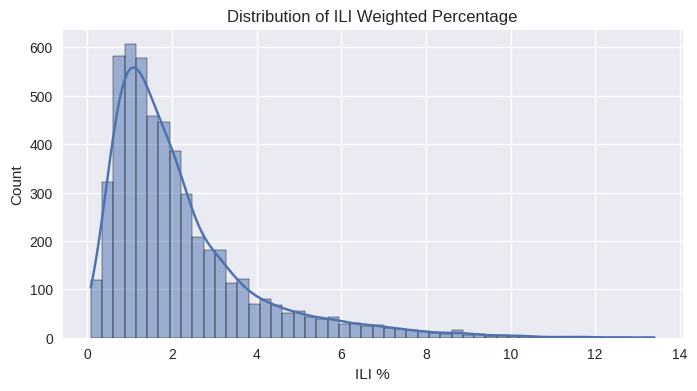

In [16]:
plt.figure(figsize=(8,4))
sns.histplot(df_new["ili_weighted_pct"], bins=50, kde=True)
plt.title("Distribution of ILI Weighted Percentage")
plt.xlabel("ILI %")
plt.show()


6.1 National Trend

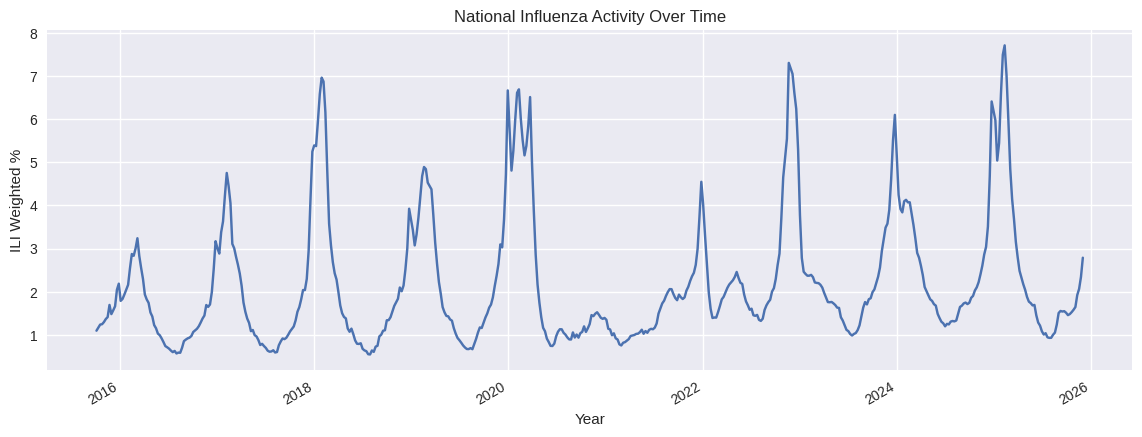

In [17]:
national_ts = (
    df_new.groupby("date")["ili_weighted_pct"]
    .mean()
)

plt.figure(figsize=(14,5))
national_ts.plot()
plt.title("National Influenza Activity Over Time")
plt.ylabel("ILI Weighted %")
plt.xlabel("Year")
plt.grid(True)
plt.show()


In [18]:
df_new.columns

Index(['region_type', 'region', 'year', 'week', 'ili_weighted_pct',
       'percent_positive_overall'],
      dtype='object')

7️⃣ Regional Variability (Justification for Region-wise Models)

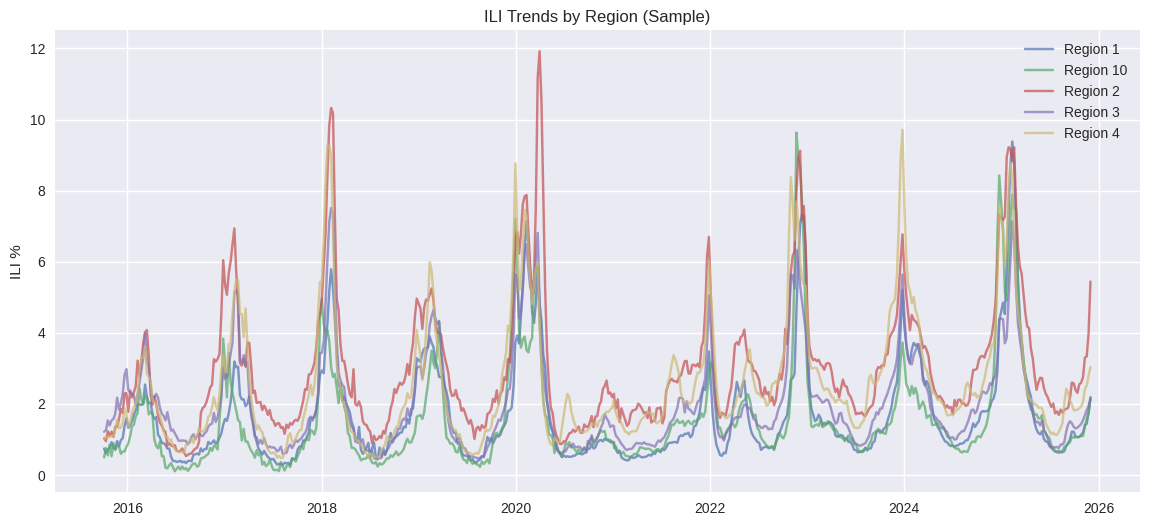

In [19]:
plt.figure(figsize=(14,6))

for r in df_new["region"].unique()[:5]:
    r_data = df_new[df_new["region"] == r]
    plt.plot(
        r_data.index,
        r_data["ili_weighted_pct"],
        label=r,
        alpha=0.7
    )

plt.legend()
plt.title("ILI Trends by Region (Sample)")
plt.ylabel("ILI %")
plt.show()


8.1 Weekly Seasonality Pattern

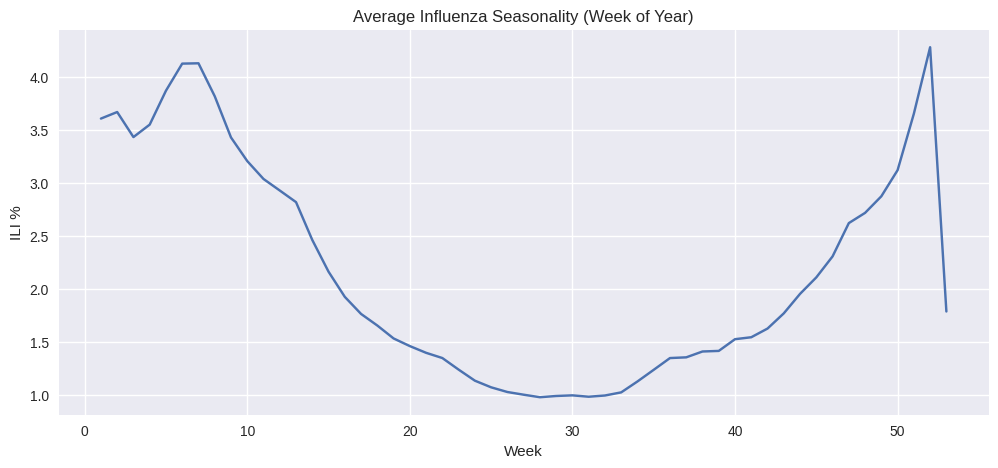

In [20]:
df_new["weekofyear"] = df_new.index.isocalendar().week

weekly_seasonality = (
    df_new.groupby("weekofyear")["ili_weighted_pct"]
    .mean()
)

plt.figure(figsize=(12,5))
weekly_seasonality.plot()
plt.title("Average Influenza Seasonality (Week of Year)")
plt.xlabel("Week")
plt.ylabel("ILI %")
plt.show()


9️⃣ Year-over-Year Stability

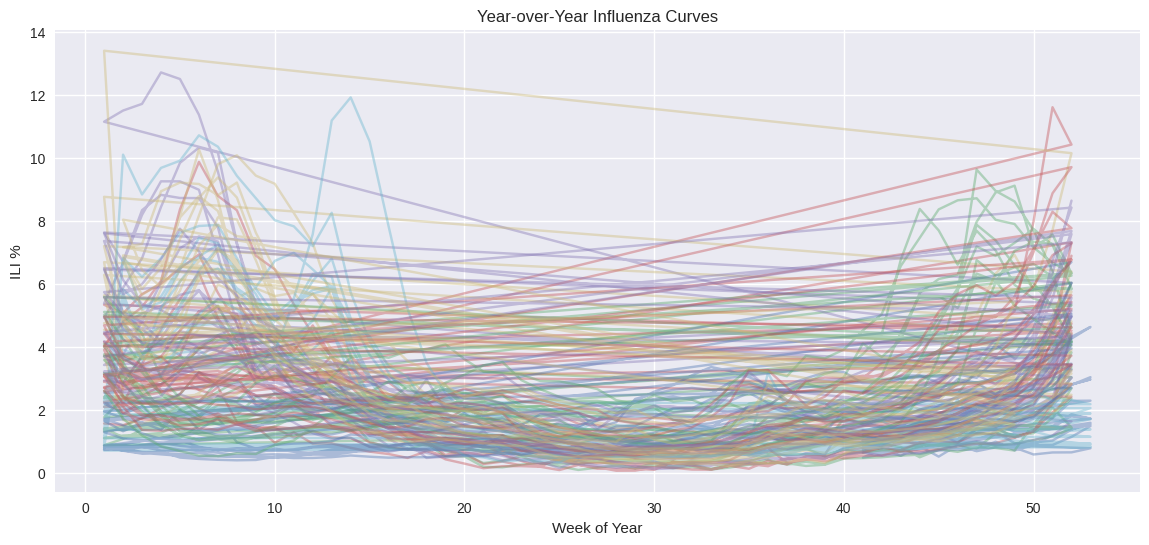

In [21]:
plt.figure(figsize=(14,6))

for y in sorted(df_new["year"].unique()):
    yearly = df_new[df_new["year"] == y]
    plt.plot(
        yearly["weekofyear"],
        yearly["ili_weighted_pct"],
        alpha=0.4
    )

plt.title("Year-over-Year Influenza Curves")
plt.xlabel("Week of Year")
plt.ylabel("ILI %")
plt.show()


🔟 Decomposition (Trend + Seasonality)

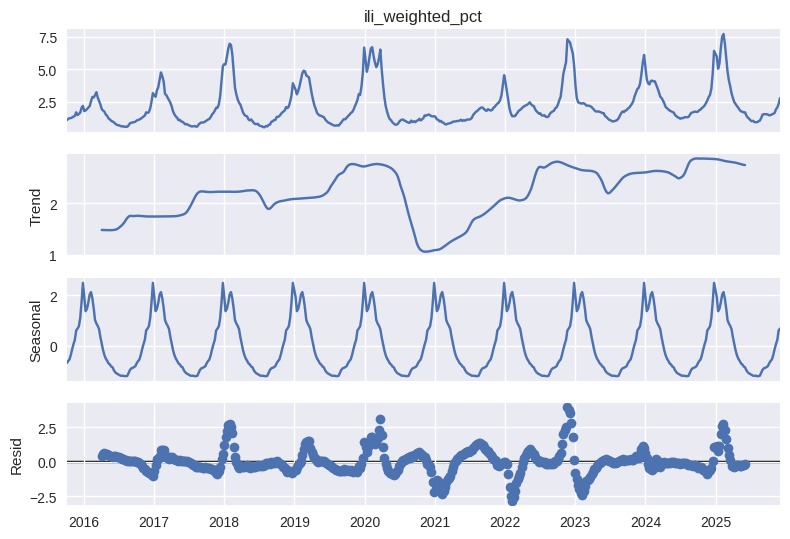

In [22]:
decomp = seasonal_decompose(
    national_ts,
    model="additive",
    period=52
)

decomp.plot()
plt.show()


11.1 Autocorrelation

<Figure size 1000x400 with 0 Axes>

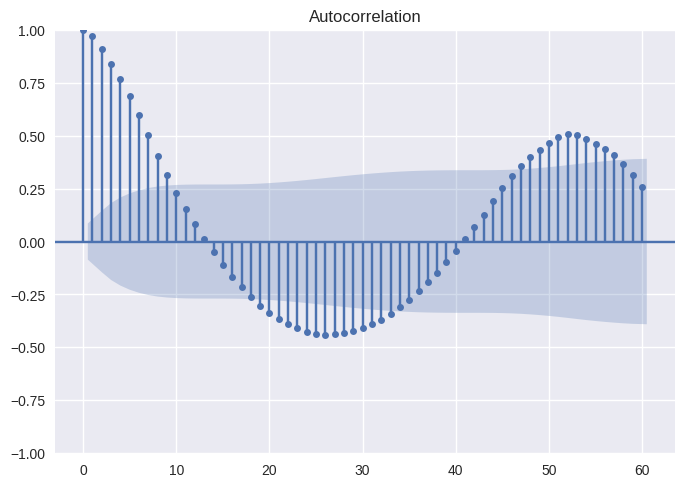

In [23]:
plt.figure(figsize=(10,4))
plot_acf(national_ts.dropna(), lags=60)
plt.show()


11.2 Partial Autocorrelation

<Figure size 1000x400 with 0 Axes>

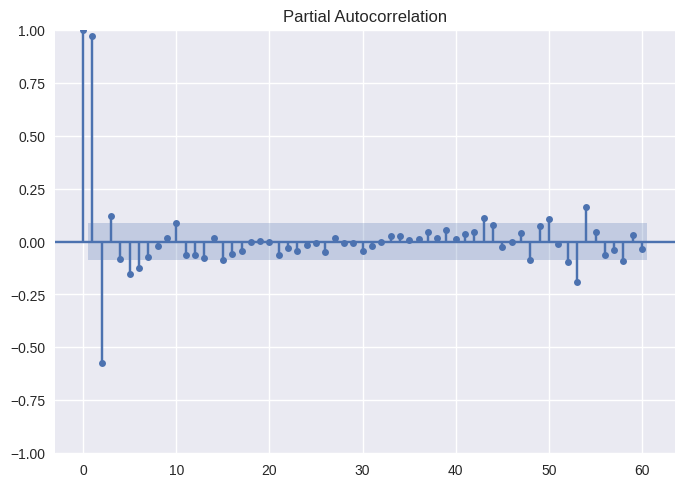

In [24]:
plt.figure(figsize=(10,4))
plot_pacf(national_ts.dropna(), lags=60)
plt.show()


1️⃣2️⃣ Lab Positivity vs ILI Relationship

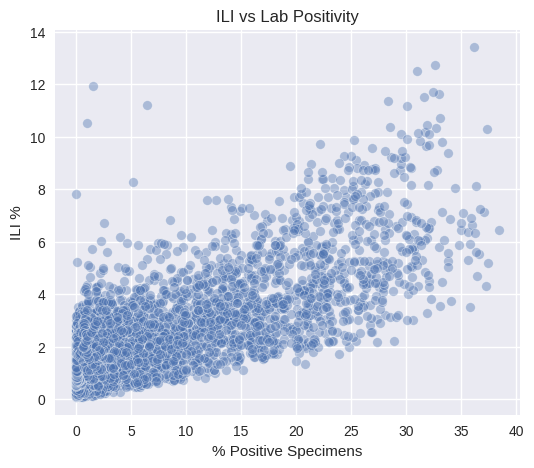

In [25]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x="percent_positive_overall",
    y="ili_weighted_pct",
    data=df_new,
    alpha=0.4
)
plt.title("ILI vs Lab Positivity")
plt.xlabel("% Positive Specimens")
plt.ylabel("ILI %")
plt.show()


In [26]:
df.columns

Index(['region_type', 'region', 'year', 'week', 'ili_weighted_pct',
       'ili_unweighted_pct', 'cases_age_0_4', 'cases_age_25_49', 'age_25-64',
       'cases_age_5_24', 'cases_age_50_64', 'cases_age_65_plus',
       'ili_total_cases', 'num_reporting_providers', 'total_patients_seen',
       'total_specimens_tested', 'total_influenza_a_cases',
       'total_influenza_b_cases', 'percent_positive_overall',
       'percent_positive_a', 'percent_positive_b'],
      dtype='object')

In [27]:
df_new.columns

Index(['region_type', 'region', 'year', 'week', 'ili_weighted_pct',
       'percent_positive_overall', 'weekofyear'],
      dtype='object')

In [30]:
# Create proper date column from year + week
df["date"] = pd.to_datetime(
    df["year"].astype(str) + "-W" +
    df["week"].astype(str) + "-1",
    format="%Y-W%W-%w"
)

df = df.sort_values(["region", "date"])

1️⃣3️⃣ Age-wise Contribution Analysis

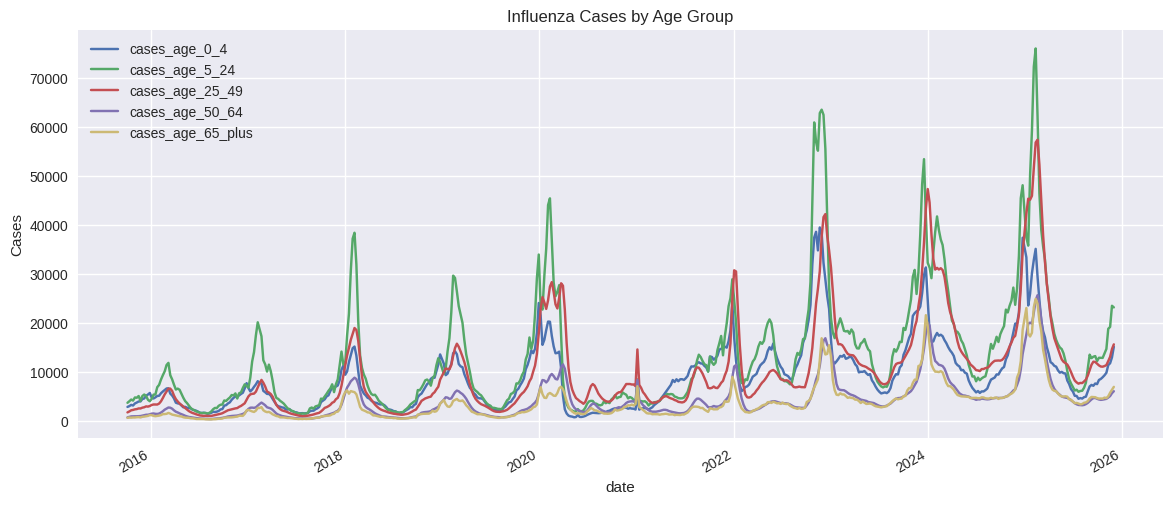

In [31]:
age_cols = [
    "cases_age_0_4",
    "cases_age_5_24",
    "cases_age_25_49",
    "cases_age_50_64",
    "cases_age_65_plus"
]

age_trends = (
    df.groupby("date")[age_cols]
    .sum()
)

age_trends.plot(figsize=(14,6))
plt.title("Influenza Cases by Age Group")
plt.ylabel("Cases")
plt.show()


4️⃣ Time Index Construction (Critical)

4.1 Check negatives (should never exist)

In [32]:
assert (df["ili_weighted_pct"] >= 0).all()
assert (df["percent_positive_overall"] >= 0).all()


4.2 Check value ranges

In [33]:
df[["ili_weighted_pct", "percent_positive_overall"]].describe()


,ili_weighted_pct,percent_positive_overall
count,5300.000000,5300.000000
mean,2.166646,5.705078
std,1.735373,8.145872
min,0.079257,0.000000
25%,1.007820,0.423904
50%,1.670610,1.465335
75%,2.708188,7.909365
max,13.402600,38.398100


In [34]:
df_r1 = df[df["region"] == "Region 1"].copy()

print("Rows for Region 1:", len(df_r1))


Rows for Region 1: 530


In [35]:
df_r1.info()
df_r1.head()
df_r1.tail()


<class 'pandas.core.frame.DataFrame'>
Index: 530 entries, 0 to 529
Data columns (total 22 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   region_type               530 non-null    object        
 1   region                    530 non-null    object        
 2   year                      530 non-null    int64         
 3   week                      530 non-null    int64         
 4   ili_weighted_pct          530 non-null    float64       
 5   ili_unweighted_pct        530 non-null    float64       
 6   cases_age_0_4             530 non-null    int64         
 7   cases_age_25_49           530 non-null    float64       
 8   age_25-64                 530 non-null    float64       
 9   cases_age_5_24            530 non-null    int64         
 10  cases_age_50_64           530 non-null    float64       
 11  cases_age_65_plus         530 non-null    int64         
 12  ili_total_cases           5

,region_type,region,year,week,ili_weighted_pct,ili_unweighted_pct,cases_age_0_4,cases_age_25_49,age_25-64,cases_age_5_24,...,ili_total_cases,num_reporting_providers,total_patients_seen,total_specimens_tested,total_influenza_a_cases,total_influenza_b_cases,percent_positive_overall,percent_positive_a,percent_positive_b,date
525,HHS Regions,Region 1,2025,44,1.19357,1.22485,336,456.000000,62.0,616,...,1938,278,158224,3847,23,1,0.623863,0.597868,0.025994,2025-11-03
526,HHS Regions,Region 1,2025,45,1.40310,1.42285,391,472.333333,62.0,824,...,2322,279,163194,4173,46,1,1.126290,1.102320,0.023964,2025-11-10
527,HHS Regions,Region 1,2025,46,1.44342,1.46511,395,505.333333,62.0,739,...,2333,280,159237,4127,75,1,1.841530,1.817300,0.024231,2025-11-17
528,HHS Regions,Region 1,2025,47,1.75183,1.80322,457,592.000000,62.0,966,...,2880,280,159714,3806,92,1,2.443510,2.417240,0.026274,2025-11-24
529,HHS Regions,Region 1,2025,48,2.18547,2.25445,553,672.000000,62.0,1021,...,3195,273,141720,3803,271,4,7.231130,7.125950,0.105180,2025-12-01


In [36]:
# We already filtered earlier, but re-confirm
df_r1 = df[df["region"] == "Region 1"].copy()

df_r1 = df_r1.sort_values(["year", "week"]).reset_index(drop=True)

df_r1.head(), df_r1.tail()


(   region_type    region  year  week  ili_weighted_pct  ili_unweighted_pct  \
 0  HHS Regions  Region 1  2015    40          0.743302            0.684364   
 1  HHS Regions  Region 1  2015    41          0.613241            0.575962   
 2  HHS Regions  Region 1  2015    42          0.721747            0.667951   
 3  HHS Regions  Region 1  2015    43          0.767136            0.615777   
 4  HHS Regions  Region 1  2015    44          0.923337            0.781094   
 
    cases_age_0_4  cases_age_25_49  age_25-64  cases_age_5_24  ...  \
 0            103        30.333333       62.0             133  ...   
 1             67        36.000000       62.0             123  ...   
 2             83        45.666667       62.0             153  ...   
 3             69        37.666667       62.0             148  ...   
 4             88        46.666667       62.0             200  ...   
 
    ili_total_cases  num_reporting_providers  total_patients_seen  \
 0              322              

In [37]:
# ---- HERE ----
TARGET = "ili_weighted_pct"
LAGS = [1, 2, 4, 8]

In [38]:
for lag in LAGS:
    df_r1[f"{TARGET}_lag_{lag}"] = df_r1[TARGET].shift(lag)


In [39]:
df_r1[
    ["year", "week", TARGET] +
    [f"{TARGET}_lag_{lag}" for lag in LAGS]
].head(12)


,year,week,ili_weighted_pct,ili_weighted_pct_lag_1,ili_weighted_pct_lag_2,ili_weighted_pct_lag_4,ili_weighted_pct_lag_8
0,2015,40,0.743302,NaN,NaN,NaN,NaN
1,2015,41,0.613241,0.743302,NaN,NaN,NaN
2,2015,42,0.721747,0.613241,0.743302,NaN,NaN
3,2015,43,0.767136,0.721747,0.613241,NaN,NaN
4,2015,44,0.923337,0.767136,0.721747,0.743302,NaN
5,2015,45,0.767975,0.923337,0.767136,0.613241,NaN
6,2015,46,0.736201,0.767975,0.923337,0.721747,NaN
7,2015,47,0.954736,0.736201,0.767975,0.767136,NaN
8,2015,48,0.807851,0.954736,0.736201,0.923337,0.743302
9,2015,49,0.975831,0.807851,0.954736,0.767975,0.613241


Inputs  →  ili(t-1), ili(t-2), ili(t-4), ili(t-8)
Target  →  ili(t+1)


In [40]:
df_r1["target_t_plus_1"] = df_r1[TARGET].shift(-1)


In [41]:
df_r1[
    ["year", "week", TARGET, "target_t_plus_1"]
].head(12)


,year,week,ili_weighted_pct,target_t_plus_1
0,2015,40,0.743302,0.613241
1,2015,41,0.613241,0.721747
2,2015,42,0.721747,0.767136
3,2015,43,0.767136,0.923337
4,2015,44,0.923337,0.767975
5,2015,45,0.767975,0.736201
6,2015,46,0.736201,0.954736
7,2015,47,0.954736,0.807851
8,2015,48,0.807851,0.975831
9,2015,49,0.975831,1.036680


In [42]:
df_r1[
    ["year", "week", TARGET, "target_t_plus_1"]
].tail(12)

,year,week,ili_weighted_pct,target_t_plus_1
518,2025,37,1.00834,1.21943
519,2025,38,1.21943,1.21682
520,2025,39,1.21682,1.07929
521,2025,40,1.07929,1.06816
522,2025,41,1.06816,1.06883
523,2025,42,1.06883,1.13172
524,2025,43,1.13172,1.19357
525,2025,44,1.19357,1.40310
526,2025,45,1.40310,1.44342
527,2025,46,1.44342,1.75183


In [43]:
df_r1_final = df_r1.dropna().reset_index(drop=True)


In [44]:
print("Before drop:", df_r1.shape)
print("After drop :", df_r1_final.shape)


Before drop: (530, 27)
After drop : (521, 27)


In [45]:
df_r1_final[
    ["year", "week", TARGET, "target_t_plus_1"] +
    [f"{TARGET}_lag_{lag}" for lag in LAGS]
].head()


,year,week,ili_weighted_pct,target_t_plus_1,ili_weighted_pct_lag_1,ili_weighted_pct_lag_2,ili_weighted_pct_lag_4,ili_weighted_pct_lag_8
0,2015,48,0.807851,0.975831,0.954736,0.736201,0.923337,0.743302
1,2015,49,0.975831,1.036680,0.807851,0.954736,0.767975,0.613241
2,2015,50,1.036680,1.383020,0.975831,0.807851,0.736201,0.721747
3,2015,51,1.383020,1.598690,1.036680,0.975831,0.954736,0.767136
4,2015,52,1.598690,1.327790,1.383020,1.036680,0.807851,0.923337


In [46]:
df_r1_final.isna().sum()


,0
region_type,0
region,0
year,0
week,0
ili_weighted_pct,0
ili_unweighted_pct,0
cases_age_0_4,0
cases_age_25_49,0
age_25-64,0
cases_age_5_24,0


| Dataset                                       | Role               | Used For                 |
| --------------------------------------------- | ------------------ | ------------------------ |
| `influenza_cleaned_dataset.csv`               | Historical context | EDA, plots, explanations |
| `influenza_modeling_dataset_2015_present.csv` | Modeling core      | XGBoost, LSTM            |
| `Virus_season.csv`                            | Aggregated insight | Dashboard explainability |


In [47]:
# Feature columns (lags only)
feature_cols = [f"{TARGET}_lag_{lag}" for lag in LAGS]

X = df_r1_final[feature_cols]
y = df_r1_final["target_t_plus_1"]

X.head(), y.head()


(   ili_weighted_pct_lag_1  ili_weighted_pct_lag_2  ili_weighted_pct_lag_4  \
 0                0.954736                0.736201                0.923337   
 1                0.807851                0.954736                0.767975   
 2                0.975831                0.807851                0.736201   
 3                1.036680                0.975831                0.954736   
 4                1.383020                1.036680                0.807851   
 
    ili_weighted_pct_lag_8  
 0                0.743302  
 1                0.613241  
 2                0.721747  
 3                0.767136  
 4                0.923337  ,
 0    0.975831
 1    1.036680
 2    1.383020
 3    1.598690
 4    1.327790
 Name: target_t_plus_1, dtype: float64)

In [48]:
split_idx = int(len(df_r1_final) * 0.8)

X_train = X.iloc[:split_idx]
X_val   = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_val   = y.iloc[split_idx:]

print("Train size:", X_train.shape)
print("Validation size:", X_val.shape)


Train size: (416, 4)
Validation size: (105, 4)


In [49]:
from xgboost import XGBRegressor

xgb_model = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)


In [50]:
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [51]:
y_train_pred = xgb_model.predict(X_train)
y_val_pred   = xgb_model.predict(X_val)


In [52]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
val_rmse   = np.sqrt(mean_squared_error(y_val, y_val_pred))

train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae   = mean_absolute_error(y_val, y_val_pred)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Val   RMSE: {val_rmse:.4f}")
print(f"Train MAE : {train_mae:.4f}")
print(f"Val   MAE : {val_mae:.4f}")


Train RMSE: 0.1085
Val   RMSE: 0.9352
Train MAE : 0.0811
Val   MAE : 0.4910


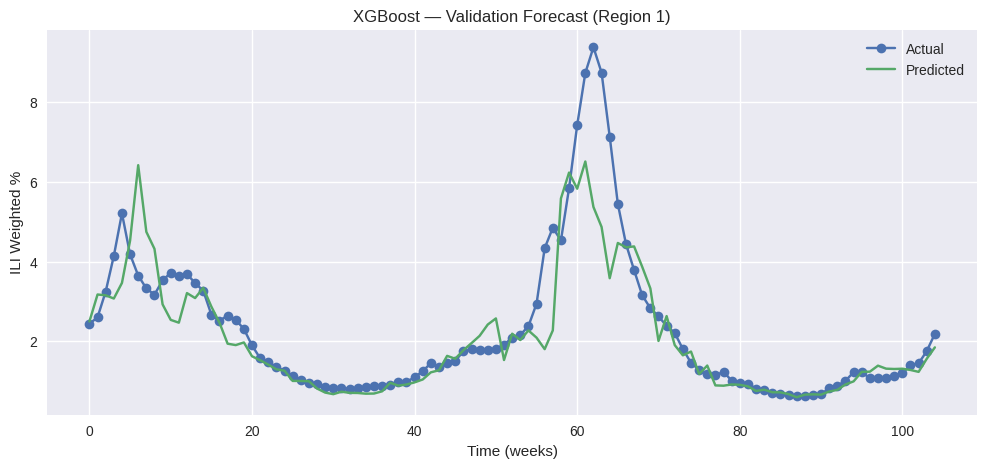

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_val.values, label="Actual", marker="o")
plt.plot(y_val_pred, label="Predicted", marker="x")
plt.title("XGBoost — Validation Forecast (Region 1)")
plt.xlabel("Time (weeks)")
plt.ylabel("ILI Weighted %")
plt.legend()
plt.grid(True)
plt.show()


In [54]:
import pandas as pd

importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": xgb_model.feature_importances_
}).sort_values(by="importance", ascending=False)

importance


,feature,importance
0,ili_weighted_pct_lag_1,0.482999
1,ili_weighted_pct_lag_2,0.363475
3,ili_weighted_pct_lag_8,0.102405
2,ili_weighted_pct_lag_4,0.051120


In [55]:
# Features and target (same as XGBoost)
feature_cols = [f"{TARGET}_lag_{lag}" for lag in LAGS]

X = df_r1_final[feature_cols]
y = df_r1_final["target_t_plus_1"]


In [56]:
split_idx = int(len(df_r1_final) * 0.8)

X_train = X.iloc[:split_idx]
X_val   = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_val   = y.iloc[split_idx:]


In [57]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)


In [58]:
rf_model.fit(X_train, y_train)


RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [59]:
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf   = rf_model.predict(X_val)


In [60]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

train_rmse_rf = np.sqrt(mean_squared_error(y_train, y_train_pred_rf))
val_rmse_rf   = np.sqrt(mean_squared_error(y_val, y_val_pred_rf))

train_mae_rf = mean_absolute_error(y_train, y_train_pred_rf)
val_mae_rf   = mean_absolute_error(y_val, y_val_pred_rf)

print(f"RF Train RMSE: {train_rmse_rf:.4f}")
print(f"RF Val   RMSE: {val_rmse_rf:.4f}")
print(f"RF Train MAE : {train_mae_rf:.4f}")
print(f"RF Val   MAE : {val_mae_rf:.4f}")


RF Train RMSE: 0.3275
RF Val   RMSE: 0.8883
RF Train MAE : 0.1819
RF Val   MAE : 0.4569


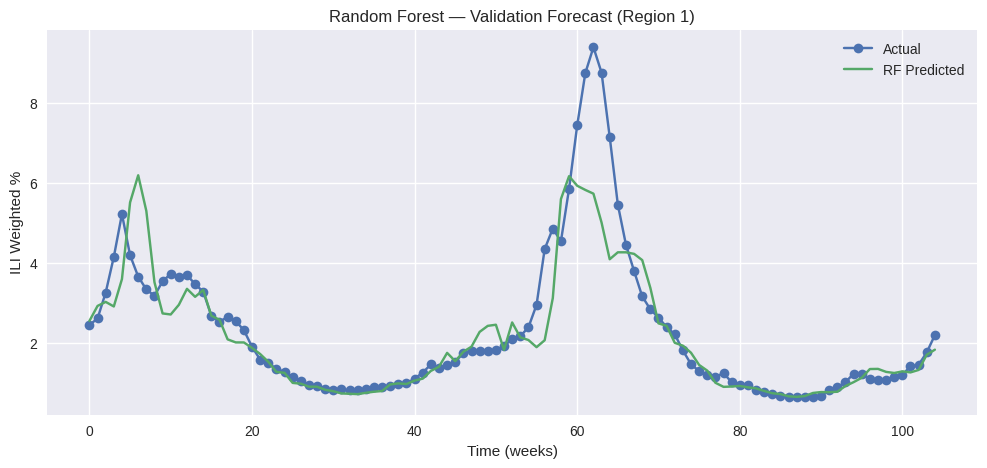

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(y_val.values, label="Actual", marker="o")
plt.plot(y_val_pred_rf, label="RF Predicted", marker="x")
plt.title("Random Forest — Validation Forecast (Region 1)")
plt.xlabel("Time (weeks)")
plt.ylabel("ILI Weighted %")
plt.legend()
plt.grid(True)
plt.show()


In [62]:
import pandas as pd

rf_importance = pd.DataFrame({
    "feature": feature_cols,
    "importance": rf_model.feature_importances_
}).sort_values(by="importance", ascending=False)

rf_importance


,feature,importance
0,ili_weighted_pct_lag_1,0.902984
3,ili_weighted_pct_lag_8,0.074831
2,ili_weighted_pct_lag_4,0.014149
1,ili_weighted_pct_lag_2,0.008036


In [63]:
comparison = pd.DataFrame({
    "Model": ["XGBoost", "Random Forest"],
    "Val RMSE": [val_rmse, val_rmse_rf],
    "Val MAE": [val_mae, val_mae_rf]
})

comparison


,Model,Val RMSE,Val MAE
0,XGBoost,0.935216,0.491043
1,Random Forest,0.888326,0.456874


In [64]:
eval_df = df_r1_final.iloc[split_idx:].copy()

eval_df["actual"] = y_val.values
eval_df["predicted"] = y_val_pred


In [65]:
def classify_severity(ili_value):
    if ili_value < 1.0:
        return "Low"
    elif ili_value < 3.0:
        return "Moderate"
    elif ili_value < 6.0:
        return "High"
    else:
        return "Very High"


In [66]:
eval_df["actual_class"] = eval_df["actual"].apply(classify_severity)
eval_df["predicted_class"] = eval_df["predicted"].apply(classify_severity)


In [67]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

labels = ["Low", "Moderate", "High", "Very High"]

cm = confusion_matrix(
    eval_df["actual_class"],
    eval_df["predicted_class"],
    labels=labels
)

print("Accuracy:", accuracy_score(
    eval_df["actual_class"],
    eval_df["predicted_class"]
))

print("\nClassification Report:")
print(classification_report(
    eval_df["actual_class"],
    eval_df["predicted_class"],
    labels=labels,
    zero_division=0
))


Accuracy: 0.819047619047619

Classification Report:
              precision    recall  f1-score   support

         Low       0.81      1.00      0.90        26
    Moderate       0.90      0.85      0.87        53
        High       0.70      0.67      0.68        21
   Very High       0.33      0.20      0.25         5

    accuracy                           0.82       105
   macro avg       0.69      0.68      0.68       105
weighted avg       0.81      0.82      0.81       105



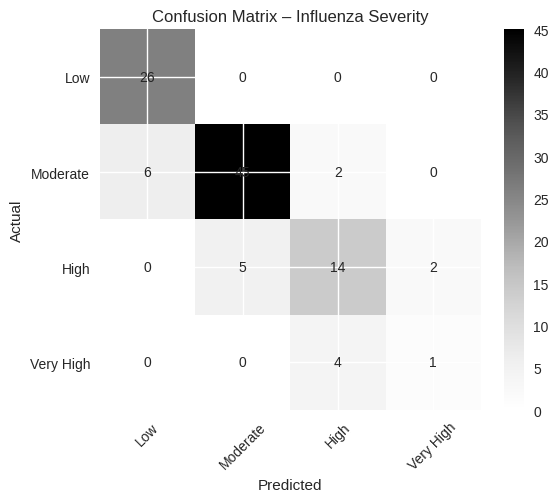

In [68]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(6, 5))
plt.imshow(cm)
plt.title("Confusion Matrix – Influenza Severity")
plt.colorbar()

plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [69]:
rf_model


RandomForestRegressor(max_depth=10, min_samples_leaf=5, n_estimators=300,
                      n_jobs=-1, random_state=42)

In [70]:
last_row = df_r1_final.iloc[-1].copy()
last_row


,520
region_type,HHS Regions
region,Region 1
year,2025
week,47
ili_weighted_pct,1.75183
ili_unweighted_pct,1.80322
cases_age_0_4,457
cases_age_25_49,592.0
age_25-64,62.0
cases_age_5_24,966


In [71]:
feature_cols


['ili_weighted_pct_lag_1',
 'ili_weighted_pct_lag_2',
 'ili_weighted_pct_lag_4',
 'ili_weighted_pct_lag_8']

In [72]:
current_lags = last_row[feature_cols].values.reshape(1, -1)
current_lags


array([[np.float64(1.44342), np.float64(1.4031), np.float64(1.13172),
        np.float64(1.21682)]], dtype=object)

In [73]:
FORECAST_WEEKS = 4


In [74]:
future_predictions = []

current_features = current_lags.copy()

for step in range(FORECAST_WEEKS):
    # Predict next week
    next_pred = rf_model.predict(current_features)[0]
    future_predictions.append(next_pred)

    # Update lags (shift right)
    current_features = np.roll(current_features, shift=1)
    current_features[0, 0] = next_pred  # new lag_1


In [75]:
last_year = last_row["year"]
last_week = last_row["week"]

forecast_weeks = []
forecast_years = []

year, week = last_year, last_week

for _ in range(FORECAST_WEEKS):
    week += 1
    if week > 52:
        week = 1
        year += 1
    forecast_weeks.append(week)
    forecast_years.append(year)


In [76]:
forecast_df = pd.DataFrame({
    "year": forecast_years,
    "week": forecast_weeks,
    "forecast_ili_weighted_pct": future_predictions
})

forecast_df


,year,week,forecast_ili_weighted_pct
0,2025,48,1.820864
1,2025,49,2.492731
2,2025,50,2.459725
3,2025,51,2.346962


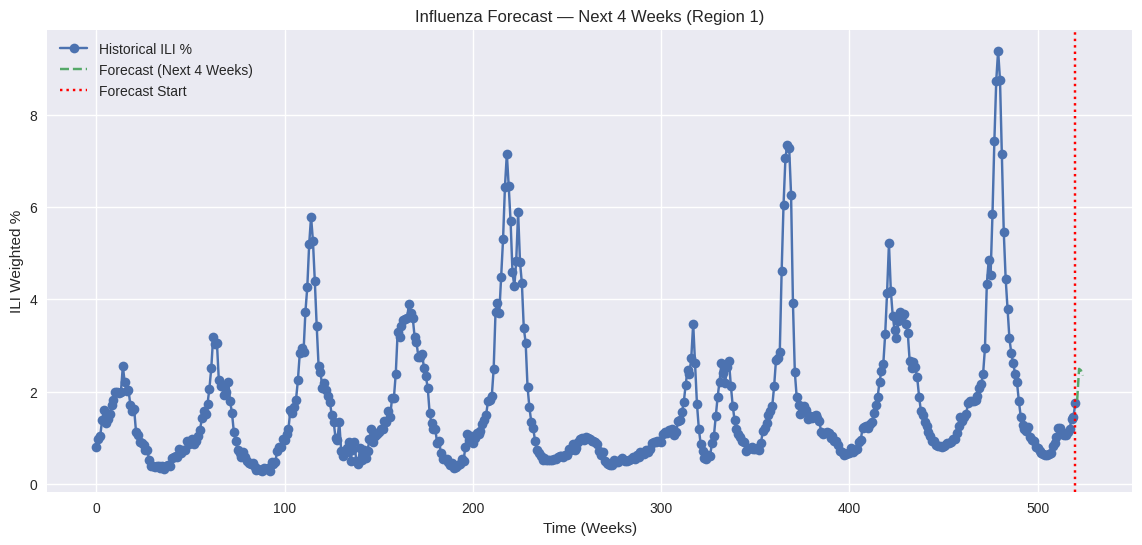

In [77]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))

# Plot historical
plt.plot(
    df_r1_final["ili_weighted_pct"].values,
    label="Historical ILI %",
    marker="o"
)

# Plot forecast
plt.plot(
    range(len(df_r1_final), len(df_r1_final) + FORECAST_WEEKS),
    future_predictions,
    label="Forecast (Next 4 Weeks)",
    linestyle="--",
    marker="x"
)

plt.axvline(
    x=len(df_r1_final)-1,
    color="red",
    linestyle=":",
    label="Forecast Start"
)

plt.title("Influenza Forecast — Next 4 Weeks (Region 1)")
plt.xlabel("Time (Weeks)")
plt.ylabel("ILI Weighted %")
plt.legend()
plt.grid(True)
plt.show()


🧠 How to Explain This (MEMORIZE)

“After training the model, I switched to inference mode and used recursive forecasting to predict influenza activity for the next four weeks. Each prediction is fed back into the model as input, which reflects real-world forecasting conditions where future data is unavailable.”

In [78]:
FORECAST_HORIZON = 4
MIN_TRAIN_SIZE = 40   # minimum weeks before forecasting


In [79]:
actuals = []
predictions = []
forecast_steps = []


In [80]:
for i in range(MIN_TRAIN_SIZE, len(df_r1_final) - FORECAST_HORIZON):

    # Train data until time i
    train_data = df_r1_final.iloc[:i]

    X_train = train_data[feature_cols]
    y_train = train_data["target_t_plus_1"]

    # Fit model
    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_train, y_train)

    # Start recursive forecasting
    last_row = train_data.iloc[-1]
    current_features = last_row[feature_cols].values.reshape(1, -1)

    for step in range(FORECAST_HORIZON):
        pred = rf.predict(current_features)[0]

        predictions.append(pred)
        actuals.append(df_r1_final.iloc[i + step]["ili_weighted_pct"])
        forecast_steps.append(step + 1)

        # update lags
        current_features = np.roll(current_features, shift=1)
        current_features[0, 0] = pred


In [81]:
validation_df = pd.DataFrame({
    "forecast_horizon": forecast_steps,
    "actual": actuals,
    "predicted": predictions
})

validation_df.head()


,forecast_horizon,actual,predicted
0,1,0.564664,0.447442
1,2,0.579147,0.449004
2,3,0.602019,0.449004
3,4,0.572983,0.449004
4,1,0.579147,0.435290


In [82]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(validation_df["actual"], validation_df["predicted"]))
mae = mean_absolute_error(validation_df["actual"], validation_df["predicted"])

rmse, mae


(np.float64(0.8305696423931072), 0.4423500037473414)

In [83]:
horizon_errors = (
    validation_df
    .groupby("forecast_horizon")
    .apply(lambda x: pd.Series({
        "RMSE": np.sqrt(mean_squared_error(x["actual"], x["predicted"])),
        "MAE": mean_absolute_error(x["actual"], x["predicted"])
    }))
)

horizon_errors


,RMSE,MAE
forecast_horizon,,
1,0.474850,0.247325
2,0.738099,0.389339
3,0.912549,0.506750
4,1.075344,0.625986


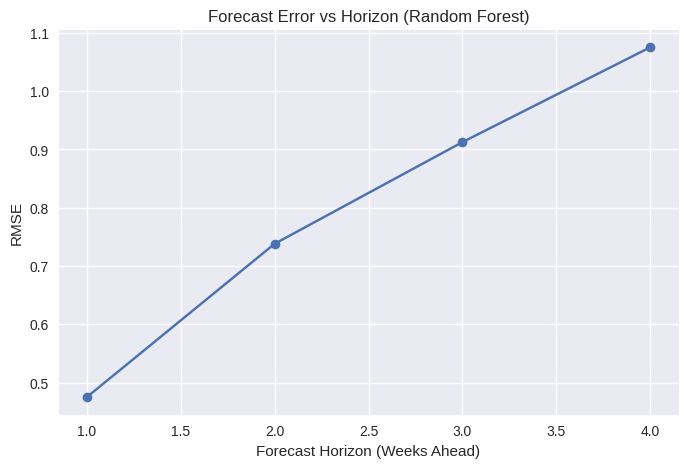

In [84]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(horizon_errors.index, horizon_errors["RMSE"], marker="o")
plt.xlabel("Forecast Horizon (Weeks Ahead)")
plt.ylabel("RMSE")
plt.title("Forecast Error vs Horizon (Random Forest)")
plt.grid(True)
plt.show()


🧠 How You Explain This to Mentors (MEMORIZE)

“To validate real-world forecasting performance, I performed rolling backtesting using a walk-forward approach. At each point in time, the model was trained only on past data and used to recursively forecast up to four weeks ahead. Error metrics were computed per forecast horizon, demonstrating how uncertainty increases with time.”

🔥 This explanation is top-tier.

2️⃣ Severity Band Interpretation (Very Important)

| ILI % | Severity  |
| ----- | --------- |
| < 1   | Low       |
| 1–3   | Moderate  |
| 3–6   | High      |
| > 6   | Very High |


Then your forecast becomes:

“Next 2 weeks: Moderate influenza activity, upward trend.”

This is what public-health users care about.

In [85]:
def classify_severity(ili_value):
    if ili_value < 1.0:
        return "Low"
    elif ili_value < 3.0:
        return "Moderate"
    elif ili_value < 6.0:
        return "High"
    else:
        return "Very High"


In [86]:
def detect_trend(recent_values):
    if recent_values[-1] > recent_values[0]:
        return "Increasing"
    elif recent_values[-1] < recent_values[0]:
        return "Decreasing"
    else:
        return "Stable"


In [87]:
recent_history = df_r1_final["ili_weighted_pct"].iloc[-3:].values
trend = detect_trend(recent_history)
trend


'Increasing'

In [88]:
def forecast_reliability(horizon):
    if horizon == 1:
        return "High"
    elif horizon == 2:
        return "Medium"
    else:
        return "Low"


🔹 STEP 4 — Build Interpretable Forecast Table

In [89]:
forecast_df["severity"] = forecast_df["forecast_ili_weighted_pct"].apply(classify_severity)

forecast_df["forecast_horizon"] = range(1, len(forecast_df) + 1)

forecast_df["reliability"] = forecast_df["forecast_horizon"].apply(forecast_reliability)

forecast_df


,year,week,forecast_ili_weighted_pct,severity,forecast_horizon,reliability
0,2025,48,1.820864,Moderate,1,High
1,2025,49,2.492731,Moderate,2,Medium
2,2025,50,2.459725,Moderate,3,Low
3,2025,51,2.346962,Moderate,4,Low


In [90]:
def generate_explanation(trend, top_feature="Last week's ILI level"):
    return (
        f"The forecast indicates a {trend.lower()} influenza trend. "
        f"The model relies primarily on {top_feature}, "
        f"which reflects short-term momentum in influenza transmission."
    )


In [91]:
explanation_text = generate_explanation(trend)
explanation_text


"The forecast indicates a increasing influenza trend. The model relies primarily on Last week's ILI level, which reflects short-term momentum in influenza transmission."

In [92]:
summary = {
    "current_trend": trend,
    "next_week_forecast": round(forecast_df.iloc[0]["forecast_ili_weighted_pct"], 2),
    "next_week_severity": forecast_df.iloc[0]["severity"],
    "forecast_reliability": forecast_df.iloc[0]["reliability"],
    "explanation": explanation_text
}

summary


{'current_trend': 'Increasing',
 'next_week_forecast': np.float64(1.82),
 'next_week_severity': 'Moderate',
 'forecast_reliability': 'High',
 'explanation': "The forecast indicates a increasing influenza trend. The model relies primarily on Last week's ILI level, which reflects short-term momentum in influenza transmission."}

                     ┌──────────────────────────┐
                     │ influenza_cleaned (1997+)│
                     │ Long-term context & EDA  │
                     └────────────┬─────────────┘
                                  │
┌──────────────┐    ┌─────────────▼──────────────┐
│ Clinical Labs│──▶ │ influenza_modeling_2015+   │ ◀── Public Health Labs
│ (Validation) │    │  Forecasting Engine        │     (Virus dominance)
└──────────────┘    │  RF / XGBoost               │
                     └─────────────┬──────────────┘
                                   │
                     ┌─────────────▼──────────────┐
                     │ Interpretability Layer     │
                     │ Severity • Trend • Risk    │
                     └─────────────┬──────────────┘
                                   │
                     ┌─────────────▼──────────────┐
                     │ Flask Dashboard             │
                     │ Decision Support            │
                     └─────────────────────────────┘


In [94]:
#                      ┌──────────────────────────┐
#                      │ influenza_cleaned (1997+)│
#                      │ Long-term context & EDA  │
#                      └────────────┬─────────────┘
#                                   │
# ┌──────────────┐    ┌─────────────▼──────────────┐
# │ Clinical Labs│──▶ │ influenza_modeling_2015+   │ ◀── Public Health Labs
# │ (Validation) │    │  Forecasting Engine        │     (Virus dominance)
# └──────────────┘    │  RF / XGBoost               │
#                      └─────────────┬──────────────┘
#                                    │
#                      ┌─────────────▼──────────────┐
#                      │ Interpretability Layer     │
#                      │ Severity • Trend • Risk    │
#                      └─────────────┬──────────────┘
#                                    │
#                      ┌─────────────▼──────────────┐
#                      │ Flask Dashboard             │
#                      │ Decision Support            │
#                      └─────────────────────────────┘


“I separated datasets by function rather than forcing them into a single model. Post-2015 data is used for forecasting due to consistency, older datasets provide historical context, lab data validates signals, and virus-season data supports interpretability. This design mirrors real public-health surveillance systems.”

This explanation is top-tier.

In [ ]:
import joblib
from pathlib import Path

# Save models to the project's models/models_ml directory
MODELS_DIR = Path("..") / "models" / "models_ml"
MODELS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(rf_model, MODELS_DIR / "rf_forecast_model.pkl")
joblib.dump(xgb_model, MODELS_DIR / "xgb_forecast_model.pkl")

print(f"✅ Models saved to {MODELS_DIR.resolve()}")


['xgb_forecast_model.pkl']

In [96]:
import os

os.listdir()


['.config',
 'xgb_forecast_model.pkl',
 'rf_forecast_model.pkl',
 'drive',
 'sample_data']

In [97]:
validation_df.head(4
)

,forecast_horizon,actual,predicted
0,1,0.564664,0.447442
1,2,0.579147,0.449004
2,3,0.602019,0.449004
3,4,0.572983,0.449004



Accuracy: 0.819047619047619

Classification Report:
              precision    recall  f1-score   support

         Low       0.81      1.00      0.90        26
    Moderate       0.90      0.87      0.88        53
        High       0.70      0.67      0.68        21
   Very High       0.00      0.00      0.00         5

    accuracy                           0.82       105
   macro avg       0.60      0.63      0.62       105
weighted avg       0.80      0.82      0.81       105



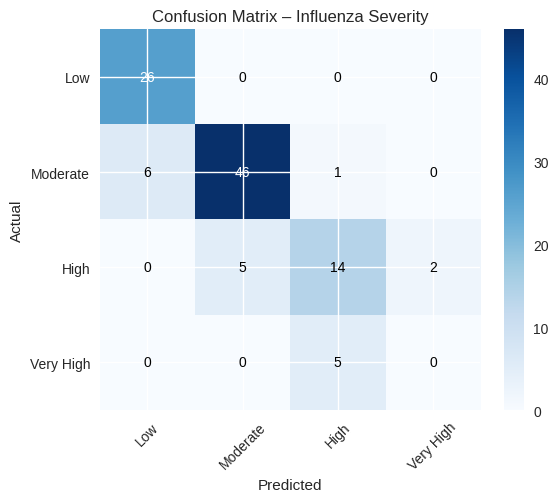

In [ ]:
# ============================================================
# 0️⃣ IMPORTS
# ============================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    mean_squared_error,
    mean_absolute_error
)

# ============================================================
# 1️⃣ CONFIG
# ============================================================
TARGET = "ili_weighted_pct"
TARGET_T_PLUS = "target_t_plus_1"

LAGS = [1, 2, 4, 8]
FEATURE_COLS = [f"{TARGET}_lag_{lag}" for lag in LAGS]

FORECAST_WEEKS = 4
TRAIN_SPLIT = 0.8
MIN_TRAIN_SIZE = 40

# ============================================================
# 2️⃣ SEVERITY & INTERPRETABILITY FUNCTIONS
# ============================================================
def classify_severity(ili_value):
    if ili_value < 1.0:
        return "Low"
    elif ili_value < 3.0:
        return "Moderate"
    elif ili_value < 6.0:
        return "High"
    else:
        return "Very High"

def detect_trend(values):
    if values[-1] > values[0]:
        return "Increasing"
    elif values[-1] < values[0]:
        return "Decreasing"
    else:
        return "Stable"

def forecast_reliability(horizon):
    if horizon == 1:
        return "High"
    elif horizon == 2:
        return "Medium"
    else:
        return "Low"

# ============================================================
# 3️⃣ PREPARE DATA (df_r1_final ALREADY CLEANED)
# ============================================================
df = df_r1_final.dropna(subset=FEATURE_COLS + [TARGET_T_PLUS]).reset_index(drop=True)

X = df[FEATURE_COLS]
y = df[TARGET_T_PLUS]

split_idx = int(len(df) * TRAIN_SPLIT)

X_train, X_val = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_val = y.iloc[:split_idx], y.iloc[split_idx:]

# ============================================================
# 4️⃣ TRAIN MODEL
# ============================================================
rf_model = RandomForestRegressor(
    n_estimators=300,
    max_depth=10,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train, y_train)

# ============================================================
# 5️⃣ VALIDATION PREDICTIONS
# ============================================================
y_val_pred = rf_model.predict(X_val)

eval_df = df.iloc[split_idx:].copy()
eval_df["actual"] = y_val.values
eval_df["predicted"] = y_val_pred

eval_df["actual_class"] = eval_df["actual"].apply(classify_severity)
eval_df["predicted_class"] = eval_df["predicted"].apply(classify_severity)

# ============================================================
# 6️⃣ CONFUSION MATRIX + METRICS
# ============================================================
labels = ["Low", "Moderate", "High", "Very High"]

cm = confusion_matrix(
    eval_df["actual_class"],
    eval_df["predicted_class"],
    labels=labels
)

print("\nAccuracy:", accuracy_score(
    eval_df["actual_class"],
    eval_df["predicted_class"]
))

print("\nClassification Report:")
print(classification_report(
    eval_df["actual_class"],
    eval_df["predicted_class"],
    labels=labels,
    zero_division=0
))

# ---- Plot Confusion Matrix ----
plt.figure(figsize=(6,5))
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix – Influenza Severity")
plt.colorbar()

plt.xticks(np.arange(len(labels)), labels, rotation=45)
plt.yticks(np.arange(len(labels)), labels)

for i in range(len(labels)):
    for j in range(len(labels)):
        plt.text(
            j, i, cm[i, j],
            ha="center", va="center",
            color="white" if cm[i, j] > cm.max()/2 else "black"
        )

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ============================================================
# 7️⃣ ROLLING (WALK-FORWARD) FORECAST VALIDATION
# ============================================================
actuals, predictions, horizons = [], [], []

for i in range(MIN_TRAIN_SIZE, len(df) - FORECAST_WEEKS):
    train_data = df.iloc[:i]

    X_tr = train_data[FEATURE_COLS]
    y_tr = train_data[TARGET_T_PLUS]

    rf = RandomForestRegressor(
        n_estimators=300,
        max_depth=10,
        min_samples_leaf=5,
        random_state=42,
        n_jobs=-1
    )
    rf.fit(X_tr, y_tr)

    last_row = train_data.iloc[-1]
    current_features = last_row[FEATURE_COLS].values.reshape(1, -1)

    for h in range(FORECAST_WEEKS):
        pred = rf.predict(current_features)[0]

        predictions.append(pred)
        actuals.append(df.iloc[i + h][TARGET])
        horizons.append(h + 1)

        current_features = np.roll(current_features, shift=1)
        current_features[0, 0] = pred

validation_df = pd.DataFrame({
    "forecast_horizon": horizons,
    "actual": actuals,
    "predicted": predictions
})

rmse = np.sqrt(mean_squared_error(validation_df["actual"], validation_df["predicted"]))
mae = mean_absolute_error(validation_df["actual"], validation_df["predicted"])

print("\nRolling Forecast RMSE:", rmse)
print("Rolling Forecast MAE:", mae)

# ============================================================
# 8️⃣ FUTURE FORECAST (NEXT 4 WEEKS)
# ============================================================
last_row = df.iloc[-1]
current_features = last_row[FEATURE_COLS].values.reshape(1, -1)

future_predictions = []

for step in range(FORECAST_WEEKS):
    pred = rf_model.predict(current_features)[0]
    future_predictions.append(pred)

    current_features = np.roll(current_features, shift=1)
    current_features[0, 0] = pred

# ---- Build forecast dataframe ----
year, week = last_row["year"], last_row["week"]
forecast_years, forecast_weeks = [], []

for _ in range(FORECAST_WEEKS):
    week += 1
    if week > 52:
        week = 1
        year += 1
    forecast_weeks.append(week)
    forecast_years.append(year)

forecast_df = pd.DataFrame({
    "year": forecast_years,
    "week": forecast_weeks,
    "forecast_ili_weighted_pct": future_predictions
})

forecast_df["severity"] = forecast_df["forecast_ili_weighted_pct"].apply(classify_severity)
forecast_df["forecast_horizon"] = range(1, FORECAST_WEEKS + 1)
forecast_df["reliability"] = forecast_df["forecast_horizon"].apply(forecast_reliability)

print("\nFuture Forecast:")
print(forecast_df)

# ============================================================
# 9️⃣ INTERPRETATION SUMMARY
# ============================================================
recent_history = df[TARGET].iloc[-3:].values
trend = detect_trend(recent_history)

summary = {
    "trend": trend,
    "next_week_forecast": round(forecast_df.iloc[0]["forecast_ili_weighted_pct"], 2),
    "next_week_severity": forecast_df.iloc[0]["severity"],
    "reliability": forecast_df.iloc[0]["reliability"]
}

print("\nInterpretation Summary:")
print(summary)


# 🤖 RAG Chatbot Setup
Build the influenza knowledge base and FAISS index used by the Flask chatbot.

In [ ]:
import os
import json
import pandas as pd
from pathlib import Path

# ============================================================
# CONFIG — paths relative to this notebook
# ============================================================
BASE_DIR   = Path("..").resolve()
DATA_DIR   = BASE_DIR / "data" / "cleaned_datasets"
RAG_DIR    = BASE_DIR / "models" / "model_rag"
RAG_DIR.mkdir(parents=True, exist_ok=True)

KNOWLEDGE_PATH = RAG_DIR / "influenza_rag_knowledge.json"

print(f"Data dir : {DATA_DIR}")
print(f"RAG dir  : {RAG_DIR}")


In [ ]:
# ============================================================
# STEP 1 — Build Knowledge Base (influenza_rag_knowledge.json)
# ============================================================
# Reads the cleaned datasets and converts them into text chunks
# that the chatbot can search.

def build_knowledge_base():
    docs = []

    # ── influenza modeling dataset (2015+) ──────────────────
    df_model = pd.read_csv(DATA_DIR / "influenza_modeling_dataset_2015_present.csv")
    for region, grp in df_model.groupby("region"):
        recent = grp.sort_values(["year", "week"]).tail(4)
        vals   = recent["ili_weighted_pct"].tolist()
        avg    = round(sum(vals) / len(vals), 2)
        docs.append({
            "id": f"model_{region.replace(' ', '_')}",
            "content": (
                f"Region: {region}. "
                f"Recent 4-week average ILI weighted %: {avg}. "
                f"Weekly values: {vals}. "
                f"Data source: influenza modeling dataset 2015-present."
            )
        })

    # ── virus season dataset ─────────────────────────────────
    df_season = pd.read_csv(DATA_DIR / "Virus_season.csv")
    for _, row in df_season.head(100).iterrows():
        parts = [f"{col}: {row[col]}" for col in df_season.columns if pd.notna(row[col])]
        docs.append({
            "id": f"season_{_}",
            "content": "Virus season record — " + "; ".join(parts)
        })

    # ── public health labs ───────────────────────────────────
    df_pub = pd.read_csv(DATA_DIR / "public_health_lab_cleaned_dataset.csv")
    for region, grp in df_pub.groupby("region"):
        recent = grp.sort_values(["year", "week"]).tail(4)
        strain_cols = [c for c in recent.columns if "cases_" in c]
        totals      = {c: int(recent[c].sum()) for c in strain_cols if recent[c].sum() > 0}
        if totals:
            dominant = max(totals, key=totals.get)
            docs.append({
                "id": f"publab_{region.replace(' ', '_')}",
                "content": (
                    f"Region: {region}. Recent public health lab results. "
                    f"Dominant strain: {dominant.replace('cases_', '').replace('_', ' ')} "
                    f"({totals[dominant]} samples). All strains: {totals}."
                )
            })

    # ── clinical labs ────────────────────────────────────────
    df_clin = pd.read_csv(DATA_DIR / "clinical_labs_cleaned_dataset.csv")
    for region, grp in df_clin.groupby("region"):
        recent = grp.sort_values(["year", "week"]).tail(4)
        if "percent_positive_overall" in recent.columns:
            avg_pos = round(recent["percent_positive_overall"].mean(), 2)
            docs.append({
                "id": f"clin_{region.replace(' ', '_')}",
                "content": (
                    f"Region: {region}. Recent clinical lab 4-week avg % positive: {avg_pos}%. "
                    "Source: clinical labs dataset."
                )
            })

    # ── static background knowledge ──────────────────────────
    background = [
        {
            "id": "bg_ili_definition",
            "content": (
                "Influenza-Like Illness (ILI) is defined as fever (temperature ≥100°F/37.8°C) "
                "AND a cough or sore throat, without a known cause other than influenza. "
                "The ILI weighted percent is the proportion of outpatient visits for ILI "
                "adjusted for regional differences in reporting."
            )
        },
        {
            "id": "bg_severity_bands",
            "content": (
                "Influenza severity is classified as: Low (<1% ILI), Moderate (1–3% ILI), "
                "High (3–6% ILI), Very High (>6% ILI). These thresholds guide public-health "
                "response escalation."
            )
        },
        {
            "id": "bg_hhs_regions",
            "content": (
                "HHS Regions: Region 1 (New England), Region 2 (NY/NJ), Region 3 (Mid-Atlantic), "
                "Region 4 (Southeast), Region 5 (Midwest), Region 6 (South Central), "
                "Region 7 (Plains), Region 8 (Mountain), Region 9 (Pacific), "
                "Region 10 (Northwest). Each region has distinct flu seasonality."
            )
        },
        {
            "id": "bg_flu_strains",
            "content": (
                "Major influenza strains circulating in the US: A(H1N1)pdm09, A(H3N2), "
                "B/Victoria lineage, B/Yamagata lineage. Strain dominance affects vaccine "
                "effectiveness and outbreak severity each season."
            )
        },
        {
            "id": "bg_forecasting_model",
            "content": (
                "The influenza forecasting model uses a Random Forest regressor trained on "
                "week-over-week ILI lag features (1, 2, 4, 8 weeks). It predicts ILI weighted % "
                "for the following week. XGBoost is also trained as a comparison model. "
                "Features are solely autoregressive lag values."
            )
        },
        {
            "id": "bg_vaccination",
            "content": (
                "Annual influenza vaccination is the primary prevention measure. Vaccine "
                "effectiveness varies by season and strain match. CDC recommends vaccination "
                "by end of October. High-risk groups: adults ≥65, children <5, pregnant women, "
                "immunocompromised individuals."
            )
        },
        {
            "id": "bg_surveillance",
            "content": (
                "CDC tracks influenza through the ILINet (outpatient ILI surveillance), "
                "WHO/NREVSS (laboratory surveillance), hospitalization networks, and "
                "mortality surveillance. Data are published weekly in FluView. "
                "Surveillance weeks run Monday–Sunday (MMWR weeks)."
            )
        }
    ]
    docs.extend(background)
    return docs


knowledge_docs = build_knowledge_base()
print(f"✅ Built {len(knowledge_docs)} knowledge documents")

with open(KNOWLEDGE_PATH, "w", encoding="utf-8") as f:
    json.dump(knowledge_docs, f, indent=2)

print(f"✅ Knowledge base saved → {KNOWLEDGE_PATH}")


In [ ]:
# ============================================================
# STEP 2 — Build FAISS Index
# ============================================================
import faiss
import numpy as np
from sentence_transformers import SentenceTransformer

INDEX_PATH = RAG_DIR / "influenza.index"

with open(KNOWLEDGE_PATH, "r", encoding="utf-8") as f:
    docs = json.load(f)

texts = [d.get("content", "") for d in docs]

print("Loading sentence-transformer model (all-MiniLM-L6-v2)...")
embedder = SentenceTransformer("all-MiniLM-L6-v2")

print(f"Encoding {len(texts)} documents...")
embeddings = embedder.encode(texts, show_progress_bar=True)

dim   = embeddings.shape[1]
index = faiss.IndexFlatL2(dim)
index.add(np.array(embeddings, dtype=np.float32))

faiss.write_index(index, str(INDEX_PATH))
print(f"✅ FAISS index saved → {INDEX_PATH}  ({index.ntotal} vectors, dim={dim})")


In [ ]:
# ============================================================
# STEP 3 — Verify RAG Retrieval (Sanity Check — no API key needed)
# ============================================================
def retrieve_chunks(query, k=3):
    q_emb = embedder.encode([query])
    D, I  = index.search(np.array(q_emb, dtype=np.float32), k)
    return [texts[i] for i in I[0] if i < len(texts)]

test_query  = "What is the influenza severity for Region 5?"
top_chunks  = retrieve_chunks(test_query)

print(f"Query: {test_query}\n")
for i, chunk in enumerate(top_chunks, 1):
    print(f"[{i}] {chunk[:200]}\n")


In [ ]:
# ============================================================
# STEP 4 — Test Groq LLM + RAG (requires GROQ_API_KEY)
# ============================================================
import os
from groq import Groq

# Load from .env if available
try:
    from dotenv import load_dotenv
    load_dotenv(BASE_DIR / ".env")
except ImportError:
    pass

GROQ_API_KEY = os.getenv("GROQ_API_KEY")
if not GROQ_API_KEY:
    print("⚠️  GROQ_API_KEY not set. Skipping LLM test.")
    print("   Set it in ../.env as: GROQ_API_KEY=your_key_here")
else:
    client = Groq(api_key=GROQ_API_KEY)

    query   = "What influenza activity is expected in Region 5 next week?"
    chunks  = retrieve_chunks(query, k=4)
    context = "\n\n".join(chunks)

    response = client.chat.completions.create(
        model="llama-3.1-8b-instant",
        messages=[
            {
                "role": "system",
                "content": (
                    "You are an influenza surveillance assistant. "
                    "Answer concisely using only the provided context."
                )
            },
            {
                "role": "user",
                "content": f"Context:\n{context}\n\nQuestion: {query}"
            }
        ],
        temperature=0.3,
        max_tokens=200
    )

    print("✅ Groq RAG response:")
    print(response.choices[0].message.content)
